In [4]:
import csv
import pandas
import numpy as np
import seaborn as sns
from scipy import stats
import tensorflow
import chess
import chess.pgn

In [47]:
stockfish = pandas.read_csv('C:\\Users\\Christopher.Atkeson\\Documents\\web_project\\chess_evaluation\\stockfish.csv')
pgn = open('C:\\Users\\Christopher.Atkeson\\Documents\\web_project\\chess_evaluation\\data.pgn')
#stockfish = pandas.read_csv('/Users/chrisatkeson/Documents/web_project/chess_evaluation/stockfish.csv')
#pgn = open('/Users/chrisatkeson/Documents/web_project/chess_evaluation/data.pgn')

In [48]:
evaluations = stockfish['MoveScores'];
all_evaluations = [];
all_positions =[];

count = 0

for game in evaluations:
    count = count+1
    print(count, len(game.split()))
    position = chess.pgn.read_game(pgn)
    for evaluation in game.split():
        all_positions.append(position.board())
        next_position = position.variations[0]
        position = next_position
        if evaluation.isdigit():
            all_evaluations.append(float(evaluation))
        elif evaluation.lstrip('-').isdigit():
            all_evaluations.append(float(evaluation.lstrip('-'))*-1.0)

In [14]:
mean_evaluation = np.mean(all_evaluations)
stdeviation = np.std(all_evaluations)
max_evaluation = np.max(all_evaluations)
min_evaluation = np.min(all_evaluations)
max_abs_evaluation = max(max_evaluation, min_evaluation*-1.0)

print(mean_evaluation)
print(max_abs_evaluation)
print(stdeviation)
print(len(all_evaluations))

29.385422529792873
12352.0
690.75661261945
4120029


In [15]:
normalized_evaluations = np.asarray(all_evaluations) * 1/max_abs_evaluation
np.random.shuffle(normalized_evaluations)

In [42]:
print(len(stockfish['MoveScores']))

50000


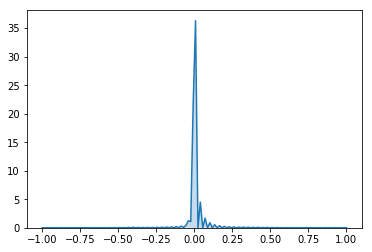

In [17]:
sns.kdeplot(normalized_evaluations[0:100000], shade=True);

In [49]:
print(pgn)
first_game = chess.pgn.read_game(pgn)
board = first_game.board()
position = first_game



<_io.TextIOWrapper name='C:\\Users\\Christopher.Atkeson\\Documents\\web_project\\chess_evaluation\\data.pgn' mode='r' encoding='cp1252'>


In [26]:
#Following Board Representation from Paper
def board_encoder(board):
    bit_boards = {"P": np.zeros(64, np.uint8),"N": np.zeros(64, np.uint8),"B": np.zeros(64, np.uint8),
                  "R": np.zeros(64, np.uint8),"Q": np.zeros(64, np.uint8),"K": np.zeros(64, np.uint8),
                  "p": np.zeros(64, np.uint8),"n": np.zeros(64, np.uint8),"b": np.zeros(64, np.uint8),
                  "r": np.zeros(64, np.uint8),"q": np.zeros(64, np.uint8),"k": np.zeros(64, np.uint8)}
    for i in range(0, 64):
        square = board.piece_at(i)
        if square is not None:
            bit_boards[square.symbol()][i] = 1
    return bit_boards
